# SEMMA: Diabetes Classification


# Phase 1: Sample

**Objectives**
- Load the dataset
- Verify schema and target distribution
- Create train/validation/test splits (stratified)

**Notes**
- For medical data, maintain class proportions with **stratified** splits.
- We'll keep a held-out validation split for honest assessment.


In [1]:
import os, pandas as pd

data_path = "/content/diabetes_dataset/diabetes.csv"

if not os.path.exists(data_path):
    raise FileNotFoundError(f"The file was not found at {data_path}. Please ensure it's uploaded.")

df = pd.read_csv(data_path)

print("Resolved path:", data_path)
print("Shape:", df.shape)
df.head()

Resolved path: /content/diabetes_dataset/diabetes.csv
Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
from sklearn.model_selection import train_test_split

if "Outcome" not in df.columns:
    raise ValueError("Expected target column 'Outcome' not found in diabetes.csv")

X_full = df.drop(columns=["Outcome"])
y_full = df["Outcome"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print("Train shape:", X_train.shape, " Valid shape:", X_valid.shape)
print("Class balance (train):")
print(y_train.value_counts(normalize=True).sort_index())

Train shape: (614, 8)  Valid shape: (154, 8)
Class balance (train):
Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64


# Phase 2: Explore

**Objectives**
- Inspect schema, missingness, ranges, and outliers
- Visualize feature distributions and correlations
- Hypothesize relationships (e.g., Glucose and BMI vs Outcome)

In [3]:
import numpy as np
print(X_full.info())
display(df.describe())

missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:")
print(missing)

# In Pima-like datasets, 0 can mean "missing" for some physiological measures
zero_as_missing = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for col in zero_as_missing:
    if col in df.columns:
        print(f"{col} zeros: {(df[col]==0).sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB
None


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Glucose zeros: 5
BloodPressure zeros: 35
SkinThickness zeros: 227
Insulin zeros: 374
BMI zeros: 11


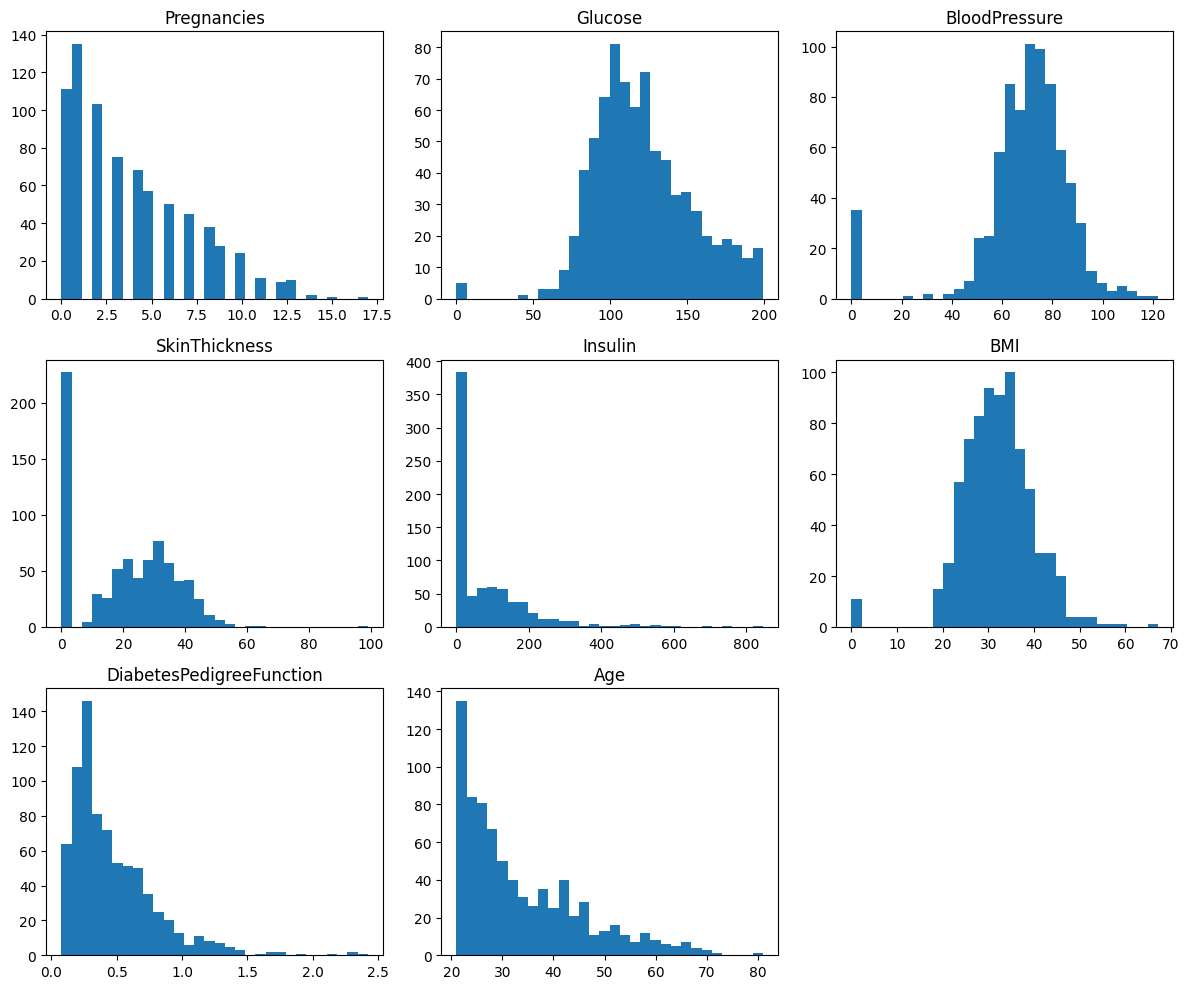

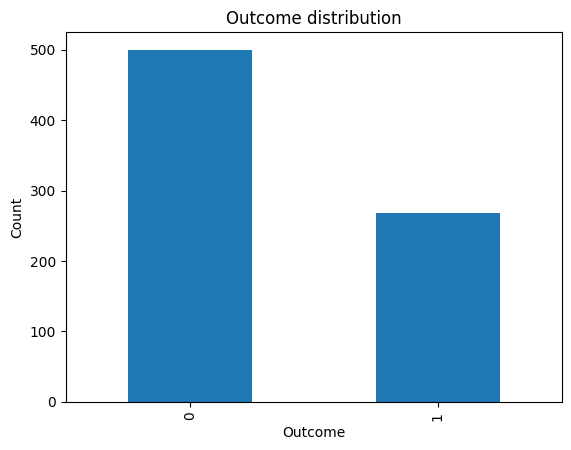

In [4]:
# Histograms for numeric features
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = X_full.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(12,10))
rows = int(np.ceil(len(numeric_cols)/3))
for i, c in enumerate(numeric_cols, 1):
    plt.subplot(rows, 3, i)
    plt.hist(df[c].dropna(), bins=30)
    plt.title(c)
plt.tight_layout()
plt.show()

# Outcome distribution
plt.figure()
y_full.value_counts().sort_index().plot(kind="bar")
plt.title("Outcome distribution")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()

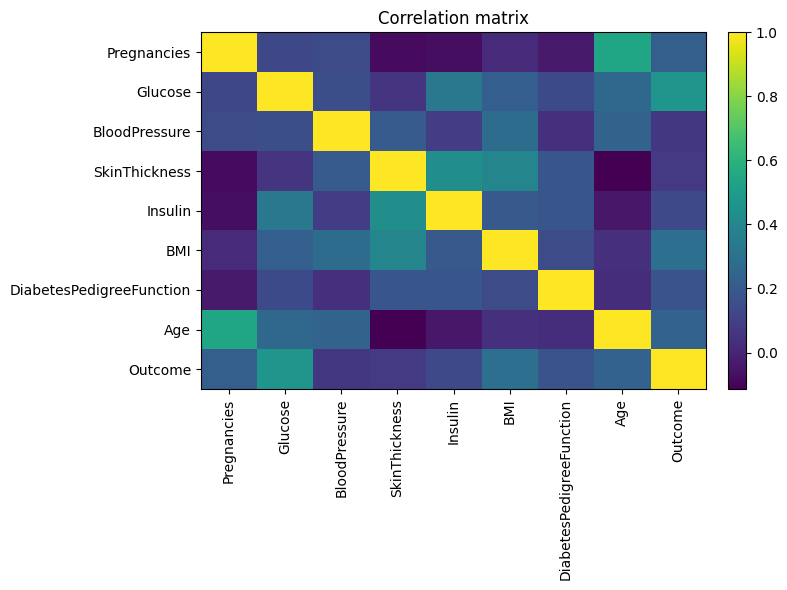

Top correlations with Outcome:
Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [5]:
# Correlation matrix (numeric only)
import numpy as np
import matplotlib.pyplot as plt

num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()

plt.figure(figsize=(8,6))
im = plt.imshow(corr.values, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

if "Outcome" in corr.columns:
    print("Top correlations with Outcome:")
    print(corr["Outcome"].sort_values(ascending=False)[:10])

# Phase 3: Modify

**Objectives**
- Impute missing/invalid values
- Scale/standardize features
- Handle class imbalance (if present)
- Optional: feature selection/engineering

**Plan**
- Convert zeros to NaN for clinical fields where zero is physiologically implausible, then impute with median.
- Standardize numeric features with `StandardScaler`.
- Use `class_weight='balanced'` for models sensitive to imbalance.


In [7]:
# Preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

zero_as_missing = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
def zero_to_nan(df_in):
    df_out = df_in.copy()
    for col in zero_as_missing:
        if col in df_out.columns:
            df_out[col] = df_out[col].replace(0, np.nan)
    return df_out

class ZeroToNaNTransformer:
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = pd.DataFrame(X, columns=num_cols+cat_cols)
        X = zero_to_nan(X)
        return X.values

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
    ],
    remainder="drop"
)

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Categorical columns: []


# Phase 4: Model

**Objectives**
- Train multiple classifiers
- Use stratified cross-validation
- Optimize for clinical relevance (ROC AUC, Recall for positive class)

**Models**
- Logistic Regression (with `class_weight='balanced'`)
- Random Forest Classifier
- Gradient Boosting Classifier


In [8]:
# Modeling with pipelines + CV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

models = {
    "LogReg": LogisticRegression(max_iter=200, class_weight="balanced", random_state=42),
    "RF": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"),
    "GB": GradientBoostingClassifier(random_state=42)
}

results = {}
for name, clf in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", clf)
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc = cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)
    results[name] = auc
    print(f"{name} ROC AUC (5-fold): mean={auc.mean():.3f} ± {auc.std():.3f}")

best_name = max(results, key=lambda k: results[k].mean())
best_clf = models[best_name]
best_pipe = Pipeline([("preprocessor", preprocessor), ("clf", best_clf)])
best_pipe.fit(X_train, y_train)

pred_proba = best_pipe.predict_proba(X_valid)[:,1]
pred = (pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_valid, pred_proba)
acc = accuracy_score(y_valid, pred)
prec = precision_score(y_valid, pred, zero_division=0)
rec = recall_score(y_valid, pred, zero_division=0)
f1 = f1_score(y_valid, pred, zero_division=0)

print(f"\nSelected model: {best_name}")
print(f"Validation ROC AUC: {auc:.3f}")
print(f"Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}")

LogReg ROC AUC (5-fold): mean=0.835 ± 0.033
RF ROC AUC (5-fold): mean=0.814 ± 0.025
GB ROC AUC (5-fold): mean=0.810 ± 0.026

Selected model: LogReg
Validation ROC AUC: 0.825
Accuracy: 0.734  Precision: 0.603  Recall: 0.704  F1: 0.650


# Phase 5: Assess

**Objectives**
- Provide comprehensive performance summary
- Visual diagnostics (ROC curve, confusion matrix, threshold sweep)
- Interpret model behavior and risks


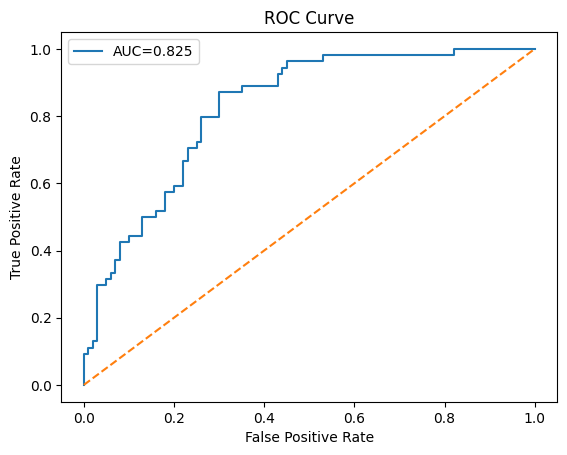

Confusion Matrix @ 0.5 threshold:
 [[75 25]
 [16 38]]


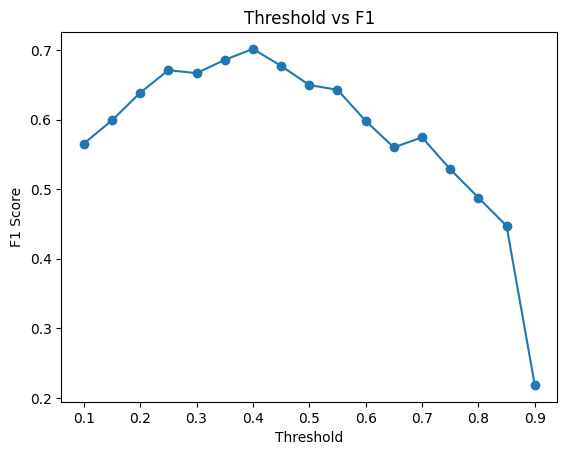

Best threshold by F1: 0.40 -> F1=0.701


In [9]:
# ROC Curve, Confusion Matrix, Threshold Sweep
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, f1_score

fpr, tpr, thr = roc_curve(y_valid, pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

cm = confusion_matrix(y_valid, pred)
print("Confusion Matrix @ 0.5 threshold:\n", cm)

thrs = np.linspace(0.1, 0.9, 17)
f1s = []
for t in thrs:
    p = (pred_proba >= t).astype(int)
    f1s.append(f1_score(y_valid, p, zero_division=0))

plt.figure()
plt.plot(thrs, f1s, marker="o")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold vs F1")
plt.show()

best_idx = int(np.argmax(f1s))
print(f"Best threshold by F1: {thrs[best_idx]:.2f} -> F1={f1s[best_idx]:.3f}")